<a href="https://colab.research.google.com/github/farenga/neuralODE/blob/main/2_Lotka_Volterra_Spiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral Lotka-Volterra

Equations:

\begin{equation}
\begin{cases}    
\dot{u_1}(t) = u_1(t)(\mu-0.1u_1(t)-0.5u_2(t)-0.5u_3(t))\\
\dot{u_2}(t) = u_2(t)(-\mu+0.5u_1(t)-0.3u_3(t))\\
\dot{u_3}(t) = u_3(t)(-\mu+0.2u_1(t)+0.5u_2(t))\\
u_i(0) = 0.5 \quad\end{cases} \qquad\mu = 1.95
\end{equation}

In [178]:
!pip install torchdiffeq

In [179]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [180]:
method = 'dopr15'
data_size = 100
batch_time = 10
batch_size = 50
niters = 1000
test_freq = 10
gpu = 0
viz = True
adjoint = False
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [181]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [182]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t = torch.linspace(0., 10., data_size).to(device)

In [183]:
mu = 1.95

In [184]:
class Lambda(nn.Module):

    def forward(self, t, u):
      u1 = u[0][0]
      u2 = u[0][1]
      u3 = u[0][2]
      return torch.tensor([ 
                            [ u1*(mu - .1*u1 - .5*u2 - .5*u3) ],
                            [ u2*(-mu + .5*u1 - .3*u3) ],
                            [ u3*(-mu + .2*u1 + .5*u2) ]
                             
                             ]).reshape([1,3]).to(device)


In [185]:
with torch.no_grad():
    true_u = odeint(Lambda(), true_u0, t, method='dopri5') # [time,state] = [t,u(t)]

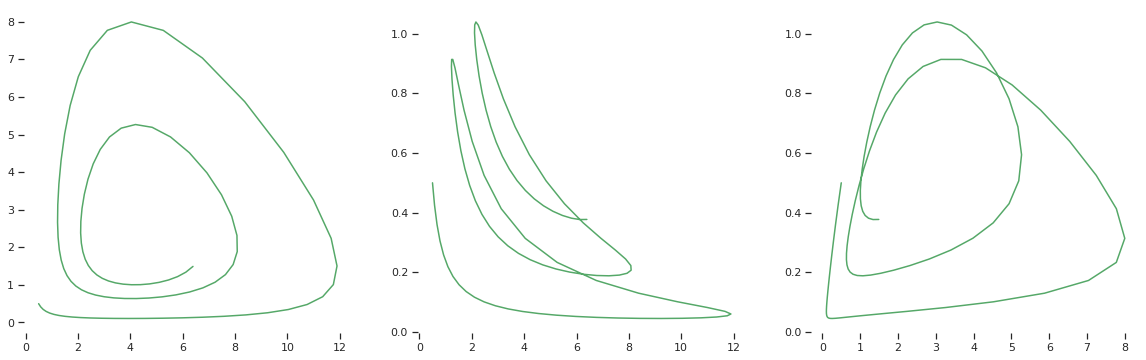

In [186]:
fig = plt.figure(figsize=(20, 6), facecolor='white')
ax_phase_1_true = fig.add_subplot(131, frameon=False)
ax_phase_1_true.plot(true_u[:, :, 0], true_u[:, :, 1], 'g-')
ax_phase_2_true = fig.add_subplot(132, frameon=False)
ax_phase_2_true.plot(true_u[:, :, 0], true_u[:, :, 2], 'g-')
ax_phase_3_true = fig.add_subplot(133, frameon=False)
ax_phase_3_true.plot(true_u[:, :, 1], true_u[:, :, 2], 'g-')

In [187]:
def get_batch():
    # generate a tensor of N=batch_size random indices in the range(0,data_size-batch_time) -> 100-10 = 90
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_u[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [188]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

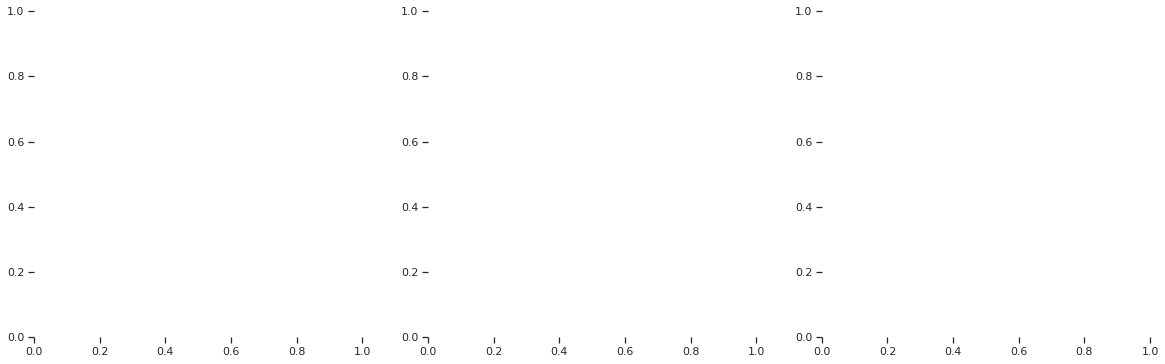

In [189]:
if viz:
    makedirs('png')
    fig = plt.figure(figsize=(20, 6), facecolor='white')
#   ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase_1 = fig.add_subplot(131, frameon=False)
    ax_phase_2 = fig.add_subplot(132, frameon=False)
    ax_phase_3 = fig.add_subplot(133, frameon=False)
#   ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [190]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_u, pred_u, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_phase_1.cla()
        ax_phase_1.set_title('Phase Portrait, Species 1-2')
        ax_phase_1.set_xlabel('x1')
        ax_phase_1.set_ylabel('x2')
        ax_phase_1.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase_1.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase_1.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 1], 'r*')
        #ax_phase_1.set_xlim(0, plot_x_lim)
        #ax_phase_1.set_ylim(0, plot_y_lim)
        
        ax_phase_2.cla()
        ax_phase_2.set_title('Phase Portrait, Species 1-3')
        ax_phase_2.set_xlabel('x1')
        ax_phase_2.set_ylabel('x3')
        ax_phase_2.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_2.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_2.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_2.set_xlim(0, plot_x_lim)
        #ax_phase_2.set_ylim(0, plot_y_lim)

        ax_phase_3.cla()
        ax_phase_3.set_title('Phase Portrait, Species 2-3')
        ax_phase_3.set_xlabel('x2')
        ax_phase_3.set_ylabel('x3')
        ax_phase_3.plot(true_u.cpu().numpy()[:, 0, 1], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_3.plot(pred_u.cpu().numpy()[:, 0, 1], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_3.plot(batch_u0.cpu().numpy()[:, 0, 1], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_3.set_xlim(0, plot_x_lim)
        #ax_phase_3.set_ylim(0, plot_y_lim)

        
        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [191]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [192]:
def lr_schedule(loss):
  if(loss < .7):
    return 1e-5
  if(loss < 1):
    return 1e-4
  else:
    return 1e-3

## Training

In [193]:
ii = 0

func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-6,  verbose=True)

loss_array = []
itr_time = []

start = time.time()
for itr in range(1, niters + 1):
    
    start_itr = time.time()

    optimizer.zero_grad()
    
    batch_u0, batch_t, batch_u = get_batch()
    pred_u = odeint(func, batch_u0, batch_t).to(device)
    
    loss = torch.mean(torch.abs(pred_u - batch_u))
    
    loss.backward()
    optimizer.step()
    
    
    itr_time.append(time.time()-start_itr)
    
    if itr % test_freq == 0:
        with torch.no_grad():
            pred_u = odeint(func, true_u0, t)
            loss = torch.mean(torch.abs(pred_u - true_u))
            loss_array.append(loss.item())
            print('Iter {:04d}  |  Total Loss {:.6f}  |  lr {:e}'.format(itr, loss.item(),optimizer.param_groups[0]['lr']))
            visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
            ii += 1
        scheduler.step(loss.item())

total_elapsed_time = time.time()-start

Iter 0010  |  Total Loss 1.246386  |  lr 1.000000e-02
Iter 0020  |  Total Loss 2.698294  |  lr 1.000000e-02
Iter 0030  |  Total Loss 1.830641  |  lr 1.000000e-02
Iter 0040  |  Total Loss 1.405902  |  lr 1.000000e-02
Iter 0050  |  Total Loss 0.688836  |  lr 1.000000e-02
Iter 0060  |  Total Loss 0.900276  |  lr 1.000000e-02
Iter 0070  |  Total Loss 1.005374  |  lr 1.000000e-02
Iter 0080  |  Total Loss 0.713321  |  lr 1.000000e-02
Iter 0090  |  Total Loss 0.964861  |  lr 1.000000e-02
Iter 0100  |  Total Loss 0.791665  |  lr 1.000000e-02
Iter 0110  |  Total Loss 1.022769  |  lr 1.000000e-02
Epoch    11: reducing learning rate of group 0 to 5.0000e-03.
Iter 0120  |  Total Loss 0.892900  |  lr 5.000000e-03
Iter 0130  |  Total Loss 0.917089  |  lr 5.000000e-03
Iter 0140  |  Total Loss 0.904759  |  lr 5.000000e-03
Iter 0150  |  Total Loss 0.932430  |  lr 5.000000e-03
Iter 0160  |  Total Loss 0.807268  |  lr 5.000000e-03
Iter 0170  |  Total Loss 0.751497  |  lr 5.000000e-03
Epoch    17: reducin

In [194]:
#!rm -r png

Text(0, 0.5, 'loss')

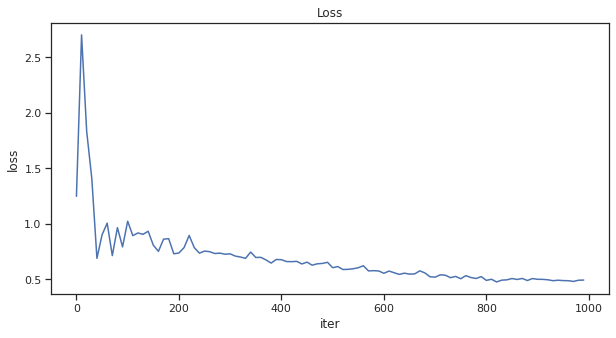

In [195]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,len(loss_array))*test_freq,loss_array,'-b')
plt.title('Loss')
plt.xlabel('iter')
plt.ylabel('loss')

In [196]:
print('Total training time: {:f} min  |  avg time per iteration : {:f} s'.format(total_elapsed_time/60, np.mean(np.array(itr_time))))

Total training time: 6.607352 min  |  avg time per iteration : 0.289083 s


In [ ]:
!zip -r /content/png.zip /content/png

## Extrapolation

In [198]:
data_size = 500
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t_train = torch.linspace(0., 10., data_size).to(device)
t_test = torch.linspace(10., 15., int(data_size/2)).to(device)
t = torch.cat([t_train,t_test[1:]],0)

with torch.no_grad():
    true_u = odeint(Lambda(), true_u0, t_train, method='dopri5') # [time,state] = [t,u(t)]
    true_u_test = odeint(Lambda(), true_u[-1], t_test, method='dopri5') # [time,state] = [t,u(t)]

In [199]:
pred_u = odeint(func, true_u0, t).to(device)

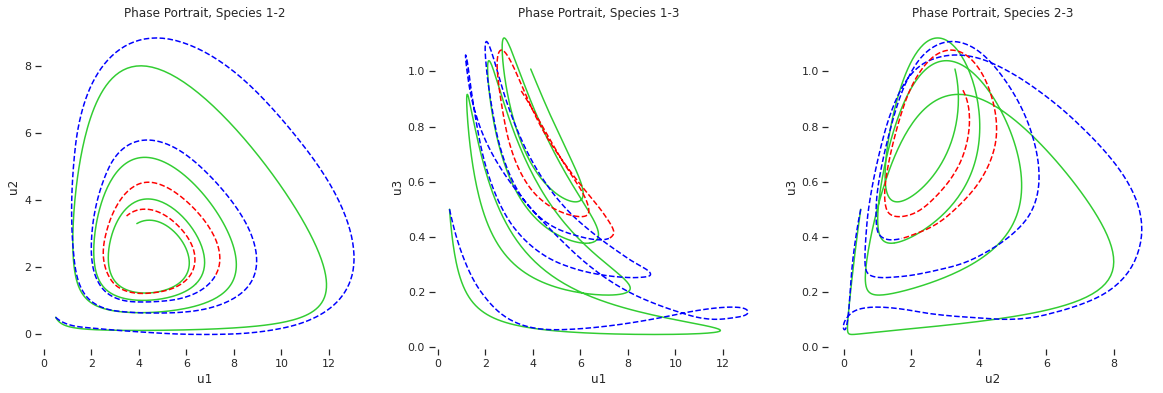

In [200]:
fig = plt.figure(figsize=(20, 6), facecolor='white')

ax_phase_1_test = fig.add_subplot(131, frameon=False)
ax_phase_1_test.set_title('Phase Portrait, Species 1-2')
ax_phase_1_test.set_xlabel('u1')
ax_phase_1_test.set_ylabel('u2')
ax_phase_1_test.plot(true_u[:, :, 0], true_u[:, :, 1], '-', color='limegreen')
ax_phase_1_test.plot(true_u_test[:, :, 0], true_u_test[:, :, 1], '-', color='limegreen')
ax_phase_1_test.plot(pred_u.detach().numpy()[:len(t_train), :, 0], pred_u.detach().numpy()[:len(t_train), :, 1], '--', color='blue')
ax_phase_1_test.plot(pred_u.detach().numpy()[len(t_train):, :, 0], pred_u.detach().numpy()[len(t_train):, :, 1], '--', color='red')

ax_phase_2_test = fig.add_subplot(132, frameon=False)
ax_phase_2_test.set_title('Phase Portrait, Species 1-3')
ax_phase_2_test.set_xlabel('u1')
ax_phase_2_test.set_ylabel('u3')
ax_phase_2_test.plot(true_u[:, :, 0], true_u[:, :, 2], '-', color='limegreen')
ax_phase_2_test.plot(true_u_test[:, :, 0], true_u_test[:, :, 2], '-', color='limegreen')
ax_phase_2_test.plot(pred_u.detach().numpy()[:len(t_train), :, 0], pred_u.detach().numpy()[:len(t_train), :, 2], '--', color='blue')
ax_phase_2_test.plot(pred_u.detach().numpy()[len(t_train):, :, 0], pred_u.detach().numpy()[len(t_train):, :, 2], '--', color='red')


ax_phase_3_test = fig.add_subplot(133, frameon=False)
ax_phase_3_test.set_title('Phase Portrait, Species 2-3')
ax_phase_3_test.set_xlabel('u2')
ax_phase_3_test.set_ylabel('u3')
ax_phase_3_test.plot(true_u[:, :, 1], true_u[:, :, 2], '-', color='limegreen')
ax_phase_3_test.plot(true_u_test[:, :, 1], true_u_test[:, :, 2], '-', color='limegreen')
ax_phase_3_test.plot(pred_u.detach().numpy()[:len(t_train), :, 1], pred_u.detach().numpy()[:len(t_train), :, 2], '--', color='blue')
ax_phase_3_test.plot(pred_u.detach().numpy()[len(t_train):, :, 1], pred_u.detach().numpy()[len(t_train):, :, 2], '--', color='red')



In [201]:
weights=[]
for w in func.parameters():
  weights.append(w.detach().numpy())

Text(0.5, 1.0, 'Layer 2 Weights Distribution')

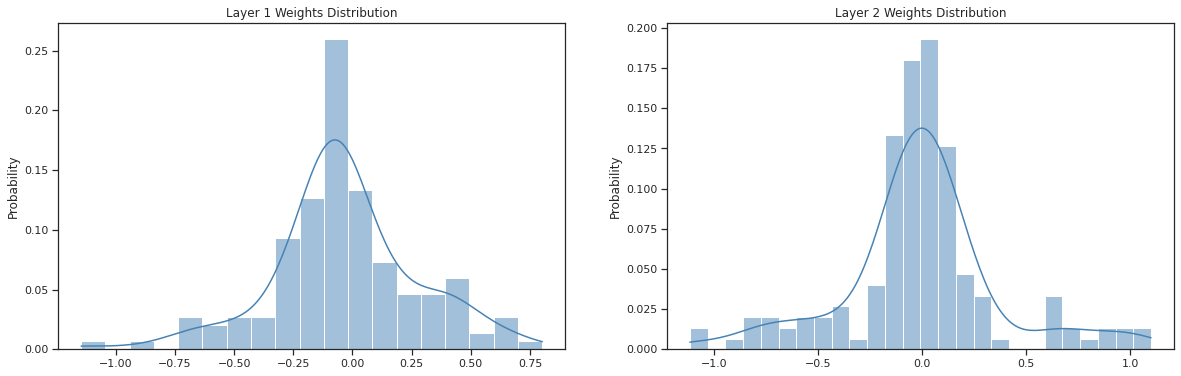

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.despine(f)

sns.histplot(weights[0].reshape(150),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[0]).set_title('Layer 1 Weights Distribution')
sns.histplot(weights[2].reshape(150),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[1]).set_title('Layer 2 Weights Distribution')